# IG Audit
Objective: Using Simple Statistical Tools and Machine Learning to Audit Instagram Accounts for Authenticity

Motivation: During lockdown, businesses have started utilising social media influencers to market their products while their physical outlets are temporary closed. However, it is sad that there are some people that will try and game the system can get for their own good. But in a world where a single influencer's post is worth as much as an average 9-5 Joe's annual salary, influencer marketing fake followers and fake engagement is a problem that brands shouldn't have to pay for. 

*Inspired by igaudit.io that was taken down by Facebook only recently.*

In [1]:
# Imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

from instagram_private_api import Client, ClientCompatPatch
import getpass

import random

## Part 1: Understanding and Splitting the Data
Dataset source: https://www.kaggle.com/eswarchandt/is-your-insta-fake-or-genuine

Import the data

In [6]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Inspect the training data

In [70]:
train.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


The features in the training data are the following:
- profile pic: does the user have a profile picture?
- nums/length username: ratio of numerical to alphabetical characters in the username
- fullname words: how many words are in the user's full name?
- nums/length fullname: ratio of numerical to alphabetical characters in the full name
- name==username: is the user's full name the same as the username?
- description length: how many characters is in the user's Instagram bio?
- external URL: does the user have an external URL linked to their profile?
- private: is the user private?
- #posts: number of posts
- #followers: number of people following the user
- #follows: number of people the user follows
- fake: if the user is fake, fake=1, else fake=0

In [4]:
train.describe()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,5.760000e+02,576.000000,576.000000
mean,0.701389,0.163837,1.460069,0.036094,0.034722,22.623264,0.116319,0.381944,107.489583,8.530724e+04,508.381944,0.500000
std,0.458047,0.214096,1.052601,0.125121,0.183234,37.702987,0.320886,0.486285,402.034431,9.101485e+05,917.981239,0.500435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.900000e+01,57.500000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.505000e+02,229.500000,0.500000
75%,1.000000,0.310000,2.000000,0.000000,0.000000,34.000000,0.000000,1.000000,81.500000,7.160000e+02,589.500000,1.000000
max,1.000000,0.920000,12.000000,1.000000,1.000000,150.000000,1.000000,1.000000,7389.000000,1.533854e+07,7500.000000,1.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   profile pic           576 non-null    int64  
 1   nums/length username  576 non-null    float64
 2   fullname words        576 non-null    int64  
 3   nums/length fullname  576 non-null    float64
 4   name==username        576 non-null    int64  
 5   description length    576 non-null    int64  
 6   external URL          576 non-null    int64  
 7   private               576 non-null    int64  
 8   #posts                576 non-null    int64  
 9   #followers            576 non-null    int64  
 10  #follows              576 non-null    int64  
 11  fake                  576 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 54.1 KB


In [8]:
train.shape

(576, 12)

Inspect the test data

In [9]:
test.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.33,1,0.33,1,30,0,1,35,488,604,0
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0
2,1,0.00,2,0.00,0,82,0,1,319,328,668,0
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,0
4,1,0.50,1,0.00,0,76,0,1,6,225,356,0


In [10]:
test.describe()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,1.200000e+02,120.000000,120.000000
mean,0.758333,0.179917,1.550000,0.071333,0.041667,27.200000,0.100000,0.308333,82.866667,4.959472e+04,779.266667,0.500000
std,0.429888,0.241492,1.187116,0.209429,0.200664,42.588632,0.301258,0.463741,230.468136,3.816126e+05,1409.383558,0.502096
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.725000e+01,119.250000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2.165000e+02,354.500000,0.500000
75%,1.000000,0.330000,2.000000,0.000000,0.000000,45.250000,0.000000,1.000000,58.250000,5.932500e+02,668.250000,1.000000
max,1.000000,0.890000,9.000000,1.000000,1.000000,149.000000,1.000000,1.000000,1879.000000,4.021842e+06,7453.000000,1.000000


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   profile pic           120 non-null    int64  
 1   nums/length username  120 non-null    float64
 2   fullname words        120 non-null    int64  
 3   nums/length fullname  120 non-null    float64
 4   name==username        120 non-null    int64  
 5   description length    120 non-null    int64  
 6   external URL          120 non-null    int64  
 7   private               120 non-null    int64  
 8   #posts                120 non-null    int64  
 9   #followers            120 non-null    int64  
 10  #follows              120 non-null    int64  
 11  fake                  120 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 11.4 KB


In [12]:
test.shape

(120, 12)

Check for NULL values

In [13]:
print(train.isna().values.any().sum())
print(test.isna().values.any().sum())

0
0


Create a correlation matrix for the features in the training data to check for significantly relevant features

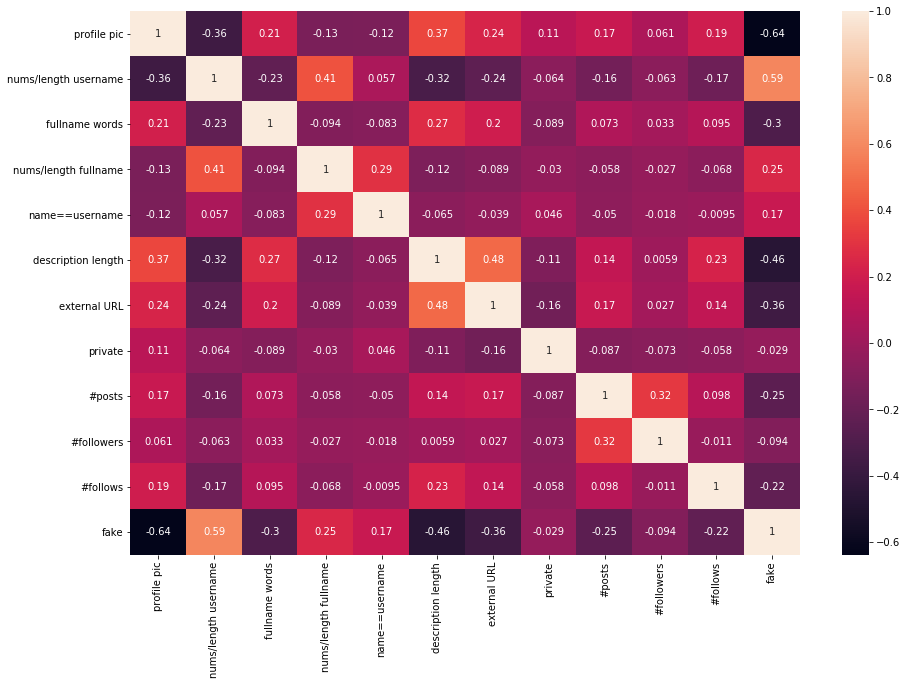

In [14]:
fig, ax = plt.subplots(figsize=(15,10))  
corr=train.corr()
sns.heatmap(corr, annot=True)

Split the training set into data and labels

In [15]:
# Labels
train_Y = train.fake
train_Y = pd.DataFrame(train_Y)

# Data
train_X = train.drop(columns='fake')
train_X.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows
0,1,0.27,0,0.0,0,53,0,0,32,1000,955
1,1,0.00,2,0.0,0,44,0,0,286,2740,533
2,1,0.10,2,0.0,0,0,0,1,13,159,98
3,1,0.00,1,0.0,0,82,0,0,679,414,651
4,1,0.00,2,0.0,0,0,0,1,6,151,126


Split the test set into data and labels

In [18]:
# Labels
test_Y = test.fake
test_Y = pd.DataFrame(test_Y)

# Data
test_X = test.drop(columns='fake')
test_X.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows
0,1,0.33,1,0.33,1,30,0,1,35,488,604
1,1,0.00,5,0.00,0,64,0,1,3,35,6
2,1,0.00,2,0.00,0,82,0,1,319,328,668
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369
4,1,0.50,1,0.00,0,76,0,1,6,225,356


## Part 2: Comparing Classification Models

**Baseline Classifier**
<br>Classify everything as the majority class.

In [22]:
# Baseline classifier
fakes = len([i for i in train.fake if i==1])
auth = len([i for i in train.fake if i==0])
fakes, auth

# classify everything as fake
pred = [1 for i in range(len(test_X))]
pred = np.array(pred)
print("Baseline accuracy: " + str(accuracy_score(pred, test_Y)))

Baseline accuracy: 0.5


**Statistical Method**
<br>Classify all users with a following to follower ratio above a certain threshold as 'fake'.
<br> i.e. a user with 10 follower and 200 followings will be classified as fake if the threshold r=20

Maximum Accuracy for the statistical method: 0.7


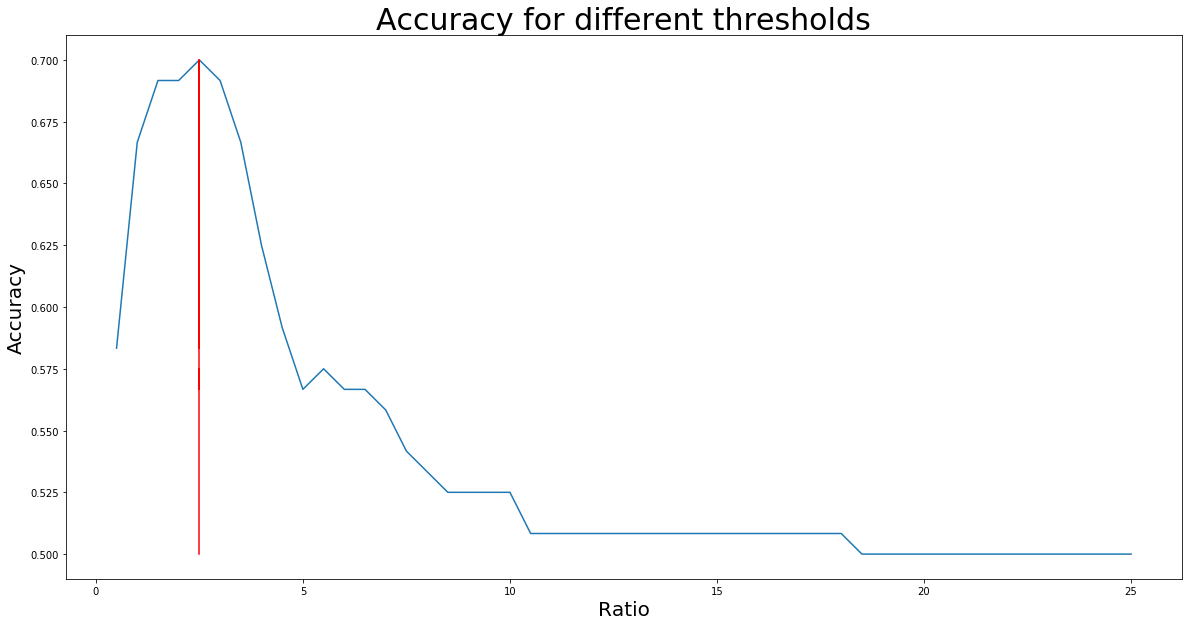

In [41]:
# Statistical method
def stat_predict(test_X, r):
    pred = []
    for row in range(len(test_X)):   
        followers = test_X.loc[row]['#followers']
        followings = test_X.loc[row]['#follows']
        if followers == 0:
            followers = 1
        if followings == 0:
            followings == 1

        ratio = followings/followers

        if ratio >= r:
            pred.append(1)
        else:
            pred.append(0)
    
    return np.array(pred)
accuracies = []
for i in [x / 10.0 for x in range(5, 255, 5)]:
    prediction = stat_predict(test_X, i)
    accuracies.append(accuracy_score(prediction, test_Y))

f, ax = plt.subplots(figsize=(20,10))
plt.plot([x / 10.0 for x in range(5, 255, 5)], accuracies)
plt.plot([2.5 for i in range(len(accuracies))], accuracies, color='red')
plt.title("Accuracy for different thresholds", size=30)
plt.xlabel('Ratio', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
print("Maximum Accuracy for the statistical method: " + str(max(accuracies)))

**Logistic Regression**

In [19]:
lm = LogisticRegression()

# Train the model
model1 = lm.fit(train_X, train_Y)

# Make a prediction
lm_predict = model1.predict(test_X)

/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [23]:
# Compute the accuracy of the model
acc = accuracy_score(lm_predict, test_Y)
print("Logistic Regression accuracy: " + str(acc))

Logistic Regression accuracy: 0.9083333333333333


**KNN Classifier**

/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/Users/athiyadeviyan

The highest accuracy obtained using KNN is 0.8666666666666667 achieved by a value of n=7


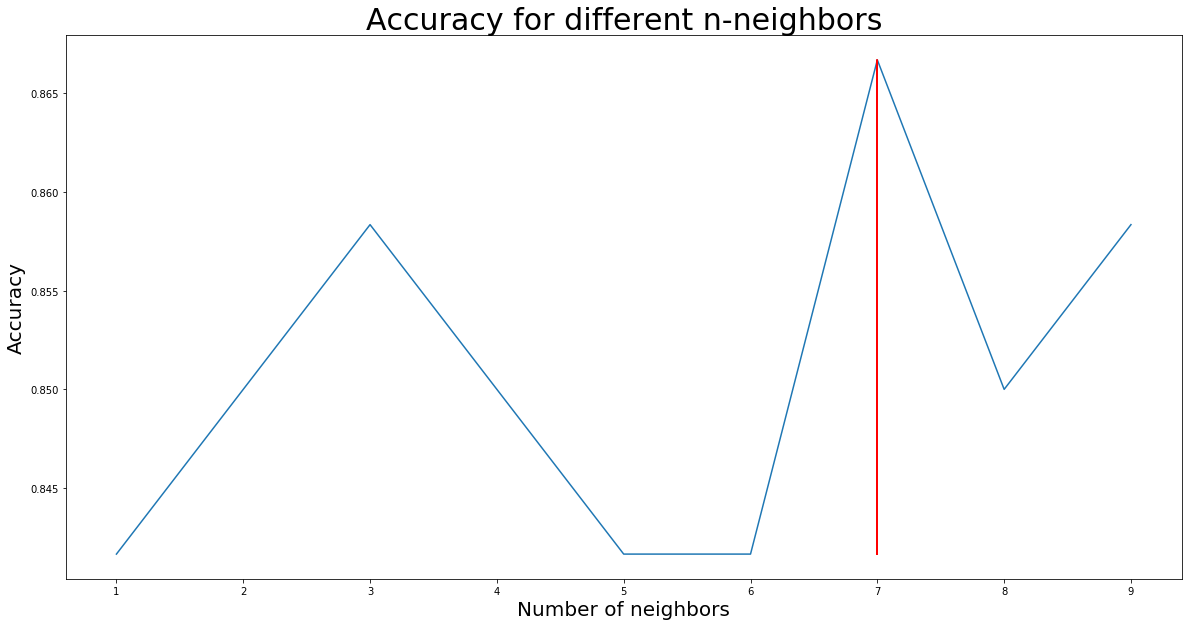

In [42]:
accuracies = []

# Compare the accuracies of using the KNN classifier with different number of neighbors
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    model_2 = knn.fit(train_X,train_Y)
    knn_predict = model_2.predict(test_X)
    accuracy = accuracy_score(knn_predict,test_Y)
    accuracies.append(accuracy)

max_acc = (0, 0)
for i in range(1, 10):
    if accuracies[i-1] > max_acc[1]:
        max_acc = (i, accuracies[i-1])

max_acc

f, ax = plt.subplots(figsize=(20,10))
plt.plot([i for i in range(1,10)], accuracies)
plt.plot([7 for i in range(len(accuracies))], accuracies, color='red')
plt.title("Accuracy for different n-neighbors", size=30)
plt.xlabel('Number of neighbors', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

print("The highest accuracy obtained using KNN is " + str(max_acc[1]) + " achieved by a value of n=" + str(max_acc[0]))

**Decision Tree Classifier**

In [43]:
DT = DecisionTreeClassifier()

# Train the model
model3 = DT.fit(train_X, train_Y)

# Make a prediction
DT_predict = model3.predict(test_X)

In [45]:
# Compute the accuracy of the model
acc = accuracy_score(DT_predict, test_Y)
print("Decision Tree accuracy: " + str(acc))

Decision Tree accuracy: 0.9


**Random Forest Classifier**

In [46]:
rfc = RandomForestClassifier()

# Train the model
model_4 = rfc.fit(train_X, train_Y)

# Make a prediction
rfc_predict = model_4.predict(test_X)

/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [47]:
# Compute the accuracy of the model
acc = accuracy_score(rfc_predict, test_Y)
print("Random Forest accuracy: " + str(acc))

Random Forest accuracy: 0.925


## Part 3: Obtaining Instagram Data
We are going to use the hassle-free unofficial Instagram API. <br> To install: ```$ pip install git+https://git@github.com/ping/instagram_private_api.git@1.6.0```

Log in to your Instagram account (preferably not your personal one! I created one just for this project 😉)

In [49]:
def login():
    username = input("username: ")
    password = getpass.getpass("password: ")
    api = Client(username, password)
    return api

api = login()

username: ins.tapolice
password: ········


Get the Instagram user ID

In [50]:
def get_ID(username):
    return api.username_info(username)['user']['pk']

In [58]:
# The user used for the experiment below is anonymised!
# i.e. this cell was run and then changed to protect the user's anonymity
userID = get_ID('<USERNAME HERE>') 

The API needs some sort of rank to query followers, posts, etc.

In [55]:
rank = api.generate_uuid()

Get the user's list follower usernames (this may take a while, depending on how many followers the user have)

In [56]:
def get_followers(userID, rank):
    followers = []
    next_max_id = True
    
    while next_max_id:
        if next_max_id == True: next_max_id=''
        f = api.user_followers(userID, rank, max_id=next_max_id)
        followers.extend(f.get('users', []))
        next_max_id = f.get('next_max_id', '')
    
    user_fer = [dic['username'] for dic in followers]
    
    return user_fer

In [59]:
followers = get_followers(userID, rank)

In [63]:
# You can check the number of followers if you'd like to
# len(followers)

## Part 4: Preparing the Data

Inspect the data (and what other data can you obtain from it) and compare it with the train and test tables above. Find out what you need to do to obtain the features for a data point in order to make a prediction.

Recall that the features for a data point are the following:
- profile pic: does the user have a profile picture?
- nums/length username: ratio of numerical to alphabetical characters in the username
- fullname words: how many words are in the user's full name?
- nums/length fullname: ratio of numerical to alphabetical characters in the full name
- name==username: is the user's full name the same as the username?
- description length: how many characters is in the user's Instagram bio?
- external URL: does the user have an external URL linked to their profile?
- private: is the user private?
- #posts: number of posts
- #followers: number of people following the user
- #follows: number of people the user follows
- fake: if the user is fake, fake=1, else fake=0

In [65]:
# This will print the first follower username on the list
# print(followers[0])

In [67]:
# This will get the information on a certain user
info = api.user_info(get_ID(followers[0]))['user']

# Check what information is available for one particular user
info.keys()

dict_keys(['pk', 'username', 'full_name', 'is_private', 'profile_pic_url', 'profile_pic_id', 'is_verified', 'has_anonymous_profile_picture', 'media_count', 'geo_media_count', 'follower_count', 'following_count', 'following_tag_count', 'biography', 'biography_with_entities', 'external_url', 'external_lynx_url', 'total_igtv_videos', 'total_clips_count', 'total_ar_effects', 'usertags_count', 'is_favorite', 'is_favorite_for_stories', 'is_favorite_for_highlights', 'live_subscription_status', 'is_interest_account', 'has_chaining', 'hd_profile_pic_versions', 'hd_profile_pic_url_info', 'mutual_followers_count', 'has_highlight_reels', 'can_be_reported_as_fraud', 'is_eligible_for_smb_support_flow', 'smb_support_partner', 'smb_delivery_partner', 'smb_donation_partner', 'smb_support_delivery_partner', 'displayed_action_button_type', 'direct_messaging', 'fb_page_call_to_action_id', 'address_street', 'business_contact_method', 'category', 'city_id', 'city_name', 'contact_phone_number', 'is_call_to_a

You can see that we have pretty much all the features to make a user data point for prediction, but we need to filter and extract them, and perform some very minor calculations. The following function will do just that:

In [75]:
def get_data(info):
    
    """Extract the information from the returned JSON.
    
    This function will return the following array:
        data = [profile pic,
                nums/length username,
                full name words,
                nums/length full name,
                name==username,
                description length,
                external URL,
                private,
                #posts,
                #followers,
                #followings]
    """
    
    data = []
    
    # Does the user have a profile photo?
    profile_pic = not info['has_anonymous_profile_picture']
    if profile_pic == True:
        profile_pic = 1
    else:
        profile_pic = 0
    data.append(profile_pic)
    
    # Ratio of number of numerical chars in username to its length
    username = info['username']
    uname_ratio = len([x for x in username if x.isdigit()]) / float(len(username))
    data.append(uname_ratio)
    
    # Full name in word tokens
    full_name = info['full_name']
    fname_tokens = len(full_name.split(' '))
    data.append(fname_tokens)
    
    # Ratio of number of numerical characters in full name to its length
    if len(full_name) == 0:
        fname_ratio = 0
    else:
        fname_ratio = len([x for x in full_name if x.isdigit()]) / float(len(full_name))
    data.append(fname_ratio)
    
    # Is name == username?
    name_eq_uname = (full_name == username)
    if name_eq_uname == True:
        name_eq_uname = 1
    else:
        name_eq_uname = 0
    data.append(name_eq_uname)
    
    # Number of characters on user bio 
    bio_length = len(info['biography'])
    data.append(bio_length)
    
    # Does the user have an external URL?
    ext_url = info['external_url'] != ''
    if ext_url == True:
        ext_url = 1
    else:
        ext_url = 0
    data.append(ext_url)
    
    # Is the user private or no?
    private = info['is_private']
    if private == True:
        private = 1
    else:
        private = 0
    data.append(private)
    
    # Number of posts
    posts = info['media_count']
    data.append(posts)
    
    # Number of followers
    followers = info['follower_count']
    data.append(followers)
    
    # Number of followings
    followings = info['following_count']
    data.append(followings)
    
  
    return data

In [73]:
# Check if the function returns as expected
get_data(info)

[1, 0.0, 3, 0.0, 0, 118, 1, 0, 589, 22227, 510]

Unfortunately the Instagram Private API has a very limited number of API calls per hour so we will not be able to analyse *all* of the user's followers. 

Fortunately, I took Statistics and learned that **random sampling** is useful to cull a smaller sample size from a larger population and use it to research and make generalizations about the larger group. 

This will allow us to make user authenticity approximations despite the API limitations and still have a data that is representative of the user's followers.

In [96]:
# Get a random sample of 50 followers
random_followers = random.sample(followers, 50)

Get user information for each follower

In [100]:
f_infos = []

for follower in random_followers:
    info = api.user_info(get_ID(follower))['user']
    f_infos.append(info)

Extract the relevant features

In [102]:
f_table = []

for info in f_infos:
    f_table.append(get_data(info))
    
f_table

[[1, 0.0, 3, 0.0, 0, 43, 0, 1, 108, 788, 764],
 [1, 0.0, 1, 0, 0, 45, 0, 0, 1, 252, 483],
 [1, 0.0, 3, 0.0, 0, 90, 0, 0, 536, 1818, 7486],
 [1, 0.5, 3, 0.0, 0, 0, 0, 0, 157, 148, 813],
 [1, 0.0, 1, 0.0, 0, 102, 0, 1, 24, 481, 592],
 [1, 0.0, 1, 0.0, 0, 59, 0, 1, 19, 773, 3639],
 [1, 0.0, 1, 0, 0, 8, 0, 1, 0, 3, 3639],
 [1, 0.0, 3, 0.0, 0, 90, 1, 0, 27, 63, 19],
 [1, 0.0, 4, 0.0, 0, 148, 0, 1, 458, 682, 436],
 [1, 0.0, 2, 0.0, 0, 0, 0, 1, 35, 1054, 1046],
 [1, 0.36363636363636365, 1, 0.0, 0, 96, 0, 1, 96, 50, 98],
 [1, 0.0, 1, 0.0, 0, 0, 0, 1, 2, 10, 202],
 [1, 0.0, 2, 0.0, 0, 135, 1, 1, 159, 52, 240],
 [1, 0.0, 1, 0.0, 0, 20, 0, 0, 87, 1864, 692],
 [1, 0.0, 1, 0.0, 0, 0, 0, 1, 35, 275, 2039],
 [1, 0.0625, 3, 0.0, 0, 98, 0, 0, 9, 98, 847],
 [1, 0.0, 3, 0.0, 0, 92, 0, 1, 10, 11, 46],
 [1, 0.0, 2, 0.0, 0, 69, 0, 1, 16, 2686, 6570],
 [1, 0.0, 2, 0.0, 0, 68, 0, 1, 31, 18, 64],
 [1, 0.0, 3, 0.0, 0, 6, 0, 0, 27, 1628, 1037],
 [1, 0.0, 1, 0, 0, 2, 0, 0, 21, 1730, 1298],
 [0, 0.1818181818181818

Create a pandas dataframe

In [103]:
test_data = pd.DataFrame(f_table,
                         columns = ['profile pic', 
                                    'nums/length username', 
                                    'fullname words',
                                    'nums/length fullname',
                                    'name==username',
                                    'description length',
                                    'external URL',
                                    'private',
                                    '#posts',
                                    '#followers',
                                    '#follows'])
test_data

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows
0,1,0.000000,3,0.000000,0,43,0,1,108,788,764
1,1,0.000000,1,0.000000,0,45,0,0,1,252,483
2,1,0.000000,3,0.000000,0,90,0,0,536,1818,7486
3,1,0.500000,3,0.000000,0,0,0,0,157,148,813
4,1,0.000000,1,0.000000,0,102,0,1,24,481,592
5,1,0.000000,1,0.000000,0,59,0,1,19,773,3639
6,1,0.000000,1,0.000000,0,8,0,1,0,3,3639
7,1,0.000000,3,0.000000,0,90,1,0,27,63,19
8,1,0.000000,4,0.000000,0,148,0,1,458,682,436
9,1,0.000000,2,0.000000,0,0,0,1,35,1054,1046


## Part 5: Make the prediction!
In part 2, we have compared the different classifiers and found that the Random Forest Classifier had the highest accuracy at 92.5%. Therefore, we are going to use this classifier to make the prediction.

In [104]:
rfc = RandomForestClassifier()

# Train the model
# We've done this in Part 2 but I'm redoing it here for coherence ☺️
rfc_model = rfc.fit(train_X, train_Y)

/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [105]:
rfc_labels = rfc_model.predict(test_data)
rfc_labels

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0])

Calculate the number of fake accounts in the random sample of 50 followers

In [106]:
no_fakes = len([x for x in rfc_labels if x==1])

Calculate the Instagram user's authenticity,
    <br>where authenticity = (#followers - #fakes)*100 / #followers

In [110]:
authenticity = (len(random_followers) - no_fakes) * 100 / len(random_followers)
print("User X's Instagram Followers is " + str(authenticity) + "% authentic.")

User X's Instagram Followers is 82.0% authentic.


## Part 6: Extension - Fake Likes
The method above can also be extended to check fake likes within a post.

Get the user's posts

In [120]:
def get_user_posts(userID, min_posts_to_be_retrieved):
    # Retrieve all posts from my profile
    my_posts = []
    has_more_posts = True
    max_id = ''
    
    while has_more_posts:
        feed = api.user_feed(userID, max_id=max_id)
        if feed.get('more_available') is not True:
            has_more_posts = False 
            
        max_id = feed.get('next_max_id', '')
        my_posts.extend(feed.get('items'))
        
        # time.sleep(2) to avoid flooding
        
        if len(my_posts) > min_posts_to_be_retrieved:
            print('Total posts retrieved: ' + str(len(my_posts)))
            return my_posts
            
        if has_more_posts:
            print(str(len(my_posts)) + ' posts retrieved so far...')
           
    print('Total posts retrieved: ' + str(len(my_posts)))
    
    return my_posts

In [121]:
posts = get_user_posts(userID, 10)

Total posts retrieved: 18


Pick one post to analyse (here I'm just going to pick by random)

In [122]:
random_post = random.sample(posts, 1)

Get post likers

In [126]:
random_post[0].keys()

dict_keys(['taken_at', 'pk', 'id', 'device_timestamp', 'media_type', 'code', 'client_cache_key', 'filter_type', 'carousel_media_count', 'carousel_media', 'can_see_insights_as_brand', 'location', 'lat', 'lng', 'user', 'can_viewer_reshare', 'caption_is_edited', 'comment_likes_enabled', 'comment_threading_enabled', 'has_more_comments', 'next_max_id', 'max_num_visible_preview_comments', 'preview_comments', 'can_view_more_preview_comments', 'comment_count', 'inline_composer_display_condition', 'inline_composer_imp_trigger_time', 'like_count', 'has_liked', 'top_likers', 'photo_of_you', 'usertags', 'caption', 'can_viewer_save', 'organic_tracking_token'])

In [127]:
likers = api.media_likers(random_post[0]['id'])

Get a list of usernames

In [130]:
likers_usernames = [liker['username'] for liker in likers['users']]

Get a random sample of 50 users

In [132]:
random_likers = random.sample(likers_usernames, 50)

Retrieve the information for the 50 users

In [135]:
l_infos = []

for liker in random_likers:
    info = api.user_info(get_ID(liker))['user']
    l_infos.append(info)

In [137]:
l_table = []

for info in l_infos:
    l_table.append(get_data(info))

l_table

[[1, 0.0, 1, 0, 0, 30, 0, 0, 6, 21, 177],
 [1, 0.0, 1, 0.0, 0, 69, 0, 1, 131, 942, 1229],
 [1, 0.0, 2, 0.0, 0, 83, 0, 1, 609, 1558, 2925],
 [1, 0.0, 1, 0.0, 0, 39, 0, 0, 851, 2940, 1255],
 [1, 0.0, 1, 0.0, 0, 36, 1, 0, 106, 1626, 1050],
 [0, 0.0, 1, 0, 0, 0, 0, 1, 7, 371, 350],
 [1, 0.0, 2, 0.0, 0, 96, 1, 0, 405, 1656, 2843],
 [1, 0.0, 2, 0.0, 0, 5, 1, 0, 9, 1363, 854],
 [1, 0.0, 1, 0, 0, 1, 0, 1, 5, 433, 371],
 [1, 0.0, 6, 0.0, 0, 93, 1, 0, 73, 1356, 1081],
 [1, 0.0, 3, 0.0, 0, 80, 1, 1, 188, 966, 966],
 [1, 0.0, 3, 0.0, 0, 0, 0, 1, 156, 1401, 1249],
 [1, 0.0, 2, 0.0, 0, 118, 1, 0, 115, 6557, 2423],
 [1, 0.0, 1, 0.0, 0, 12, 0, 0, 84, 1552, 661],
 [1, 0.0, 1, 0.0, 0, 80, 0, 0, 99, 1413, 2479],
 [1, 0.0, 1, 0.0, 0, 23, 0, 1, 12, 1116, 1031],
 [1, 0.0, 1, 0.0, 0, 20, 0, 0, 87, 1864, 692],
 [1, 0.0, 3, 0.0, 0, 62, 1, 0, 17, 1266, 1107],
 [1, 0.0, 2, 0.0, 0, 20, 0, 1, 15, 636, 579],
 [1, 0.0, 4, 0.0, 0, 17, 0, 1, 127, 546, 536],
 [1, 0.0, 1, 0.0, 0, 18, 0, 0, 5, 918, 678],
 [1, 0.285714285

In [138]:
# Generate pandas dataframe 
l_test_data = pd.DataFrame(l_table,
                         columns = ['profile pic', 
                                    'nums/length username', 
                                    'fullname words',
                                    'nums/length fullname',
                                    'name==username',
                                    'description length',
                                    'external URL',
                                    'private',
                                    '#posts',
                                    '#followers',
                                    '#follows'])
l_test_data

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows
0,1,0.000000,1,0.0,0,30,0,0,6,21,177
1,1,0.000000,1,0.0,0,69,0,1,131,942,1229
2,1,0.000000,2,0.0,0,83,0,1,609,1558,2925
3,1,0.000000,1,0.0,0,39,0,0,851,2940,1255
4,1,0.000000,1,0.0,0,36,1,0,106,1626,1050
5,0,0.000000,1,0.0,0,0,0,1,7,371,350
6,1,0.000000,2,0.0,0,96,1,0,405,1656,2843
7,1,0.000000,2,0.0,0,5,1,0,9,1363,854
8,1,0.000000,1,0.0,0,1,0,1,5,433,371
9,1,0.000000,6,0.0,0,93,1,0,73,1356,1081


Finally, make the prediction!

In [139]:
rfc = RandomForestClassifier()
rfc_model = rfc.fit(train_X, train_Y)
rfc_labels_likes = rfc_model.predict(l_test_data)
rfc_labels_likes

/Users/athiyadeviyani/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0])

Calculate the fake accounts that liked the user's media

In [140]:
no_fake_likes = len([x for x in rfc_labels_likes if x==1])

Calculate the media likes authenticity

In [143]:
media_authenticity = (len(random_likers) - no_fake_likes) * 100 / len(random_likers)
print("The media with the ID:XXXXX has " + str(media_authenticity) + "% authentic likes.")

The media with the ID:XXXXX has 92.0% authentic likes.


## Part 7: Comparison With Another User
I have specifically chosen user X because I trusted their social media 'game' and seemed to have a loyal and engaged following. Let's compare their metrics with a user Y, a user that has a noticable follower growth spike when examined on SocialBlade.

I am going to skip the explanation here because it's just a repetition of the steps performed on user X.

In [144]:
# Re-login because of API call limits 
api = login()

username: ins.tafakebusters
password: ········


In [145]:
userID_y = get_ID('<USERNAME>')

In [146]:
rank = api.generate_uuid()

**USER Y FOLLOWERS ANALYSIS**

In [147]:
y_followers = get_followers(userID_y, rank)

In [162]:
y_random_followers = random.sample(y_followers, 50)

In [164]:
y_infos = []

for follower in y_random_followers:
    info = api.user_info(get_ID(follower))['user']
    y_infos.append(info)

In [165]:
y_table = []

for info in y_infos:
    y_table.append(get_data(info))
    
y_table

[[1, 0.14285714285714285, 1, 0.0, 0, 0, 0, 0, 16, 32, 1549],
 [1, 0.2222222222222222, 1, 0.0, 0, 0, 0, 1, 15, 337, 2058],
 [1, 0.25, 2, 0.0, 0, 0, 0, 0, 5, 310, 6343],
 [1, 0.0, 4, 0.0, 0, 97, 0, 0, 1, 14107, 7514],
 [1, 0.36363636363636365, 2, 0.0, 0, 0, 0, 0, 16, 8, 1050],
 [1, 0.25, 2, 0.0, 0, 13, 0, 0, 15, 87, 6741],
 [1, 0.0, 1, 0, 0, 0, 0, 1, 21, 24, 5862],
 [1, 0.0, 1, 0, 0, 13, 0, 1, 27, 1289, 689],
 [1, 0.0, 1, 0.0, 0, 29, 0, 1, 0, 31, 148],
 [1, 0.0, 1, 0, 0, 119, 0, 0, 32, 636, 1293],
 [1, 0.0, 4, 0.0, 0, 20, 0, 0, 144, 3617, 1346],
 [1, 0.21428571428571427, 2, 0.0, 0, 0, 0, 0, 17, 71, 7495],
 [1, 0.13333333333333333, 2, 0.0, 0, 113, 0, 1, 3, 305, 303],
 [0, 0.4444444444444444, 2, 0.0, 0, 0, 0, 1, 1, 63, 283],
 [1, 0.0, 3, 0.0, 0, 0, 0, 0, 17, 115, 7506],
 [0, 0.0625, 2, 0.0, 0, 0, 0, 1, 272, 1446, 2362],
 [1, 0.15384615384615385, 2, 0.0, 0, 0, 0, 0, 6, 1150, 732],
 [1, 0.0, 2, 0.0, 0, 0, 0, 0, 15, 60, 1631],
 [1, 0.0, 1, 0, 0, 13, 0, 0, 15, 11, 221],
 [1, 0.0, 1, 0, 0, 1, 0

In [166]:
# Generate pandas dataframe 
y_test_data = pd.DataFrame(y_table,
                         columns = ['profile pic', 
                                    'nums/length username', 
                                    'fullname words',
                                    'nums/length fullname',
                                    'name==username',
                                    'description length',
                                    'external URL',
                                    'private',
                                    '#posts',
                                    '#followers',
                                    '#follows'])
y_test_data

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows
0,1,0.142857,1,0.000000,0,0,0,0,16,32,1549
1,1,0.222222,1,0.000000,0,0,0,1,15,337,2058
2,1,0.250000,2,0.000000,0,0,0,0,5,310,6343
3,1,0.000000,4,0.000000,0,97,0,0,1,14107,7514
4,1,0.363636,2,0.000000,0,0,0,0,16,8,1050
5,1,0.250000,2,0.000000,0,13,0,0,15,87,6741
6,1,0.000000,1,0.000000,0,0,0,1,21,24,5862
7,1,0.000000,1,0.000000,0,13,0,1,27,1289,689
8,1,0.000000,1,0.000000,0,29,0,1,0,31,148
9,1,0.000000,1,0.000000,0,119,0,0,32,636,1293


In [167]:
# Predict (no retraining!)
rfc_labels_y = rfc_model.predict(y_test_data)
rfc_labels_y

array([1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1])

In [168]:
# Calculate the number of fake accounts in the random sample of 50 followers
no_fakes_y = len([x for x in rfc_labels_y if x==1])

In [216]:
# Calculate the authenticity
y_authenticity = (len(y_random_followers) - no_fakes_y) * 100 / len(y_random_followers)
print("User Y's Instagram Followers is " + str(y_authenticity) + "% authentic.")

User Y's Instagram Followers is 38.0% authentic.


Ahh, the joys of being right!

**USER Y LIKES ANALYSIS**

In [191]:
y_posts = get_user_posts(userID_y, 10)

Total posts retrieved: 18


In [192]:
y_random_post = random.sample(y_posts, 1)

In [193]:
y_likers = api.media_likers(y_random_post[0]['id'])

In [194]:
y_likers_usernames = [liker['username'] for liker in y_likers['users']]

In [207]:
y_random_likers = random.sample(y_likers_usernames, 50)

In [210]:
y_likers_infos = []

for liker in y_random_likers:
    info = api.user_info(get_ID(liker))['user']
    y_likers_infos.append(info)

In [211]:
y_likers_table = []

for info in y_likers_infos:
    y_likers_table.append(get_data(info))
    
y_likers_table

[[1, 0.0, 2, 0.0, 0, 0, 0, 0, 2, 897, 830],
 [0, 0.0, 2, 0.0, 0, 0, 0, 1, 0, 129, 132],
 [1, 0.0, 2, 0.0, 0, 8, 0, 1, 72, 1157, 698],
 [1, 0.0, 1, 0, 0, 10, 0, 1, 6, 1410, 619],
 [1, 0.0, 1, 0.0, 0, 0, 0, 0, 0, 1916, 731],
 [1, 0.2222222222222222, 3, 0.0, 0, 72, 0, 1, 13, 950, 649],
 [1, 0.0, 1, 0.0, 0, 19, 0, 1, 17, 1543, 1289],
 [1, 0.2, 5, 0.0, 0, 11, 0, 0, 33, 1076, 606],
 [1, 0.0, 1, 0.0, 0, 104, 0, 1, 6, 202, 485],
 [1, 0.2, 1, 0.0, 0, 15, 0, 0, 7, 1262, 679],
 [1, 0.15384615384615385, 2, 0.0, 0, 0, 0, 0, 6, 1150, 732],
 [1, 0.0, 1, 0.0, 0, 17, 1, 0, 28, 2442, 629],
 [1, 0.0, 2, 0.0, 0, 61, 0, 0, 159, 556, 765],
 [1, 0.0, 2, 0.0, 0, 34, 0, 1, 10, 531, 526],
 [1, 0.0, 3, 0.0, 0, 127, 0, 0, 23, 1137, 909],
 [1, 0.0, 2, 0.0, 0, 66, 0, 1, 25, 583, 805],
 [1, 0.13333333333333333, 2, 0.0, 0, 67, 1, 0, 141, 4615, 1948],
 [1, 0.0, 2, 0.0, 0, 47, 0, 1, 387, 75, 162],
 [1, 0.0, 1, 0.0, 0, 142, 0, 1, 8144, 664, 1527],
 [1, 0.0, 3, 0.0, 0, 4, 0, 1, 1, 466, 325],
 [1, 0.058823529411764705, 1,

In [212]:
y_likers_data = pd.DataFrame(y_likers_table,
                         columns = ['profile pic', 
                                    'nums/length username', 
                                    'fullname words',
                                    'nums/length fullname',
                                    'name==username',
                                    'description length',
                                    'external URL',
                                    'private',
                                    '#posts',
                                    '#followers',
                                    '#follows'])
y_likers_data

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows
0,1,0.000000,2,0.0,0,0,0,0,2,897,830
1,0,0.000000,2,0.0,0,0,0,1,0,129,132
2,1,0.000000,2,0.0,0,8,0,1,72,1157,698
3,1,0.000000,1,0.0,0,10,0,1,6,1410,619
4,1,0.000000,1,0.0,0,0,0,0,0,1916,731
5,1,0.222222,3,0.0,0,72,0,1,13,950,649
6,1,0.000000,1,0.0,0,19,0,1,17,1543,1289
7,1,0.200000,5,0.0,0,11,0,0,33,1076,606
8,1,0.000000,1,0.0,0,104,0,1,6,202,485
9,1,0.200000,1,0.0,0,15,0,0,7,1262,679


In [213]:
# Predict!
y_likers_pred = rfc_model.predict(y_likers_data)
y_likers_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0])

In [218]:
# Calculate the number of fake likes
no_fakes_yl = len([x for x in y_likers_pred if x==1])

# Calculate media likes authenticity
y_post_authenticity = (len(y_random_likers) - no_fakes_yl) * 100 / len(y_random_likers)
print("The media with the ID:YYYYY has " + str(y_post_authenticity) + "% authentic likes.")

The media with the ID:YYYYY has 96.0% authentic likes.


Very high likes authenticity but very low follower authenticity? How is that possible?

We can use **engagement rates** to explain this phenomena further.

Engagement rate = average number of engagements (likes+comments) / number of followers)

In [220]:
y_posts[0].keys()

dict_keys(['taken_at', 'pk', 'id', 'device_timestamp', 'media_type', 'code', 'client_cache_key', 'filter_type', 'carousel_media_count', 'carousel_media', 'can_see_insights_as_brand', 'location', 'lat', 'lng', 'user', 'can_viewer_reshare', 'caption_is_edited', 'comment_likes_enabled', 'comment_threading_enabled', 'has_more_comments', 'max_num_visible_preview_comments', 'preview_comments', 'can_view_more_preview_comments', 'comment_count', 'inline_composer_display_condition', 'inline_composer_imp_trigger_time', 'like_count', 'has_liked', 'top_likers', 'photo_of_you', 'caption', 'can_viewer_save', 'organic_tracking_token'])

In [226]:
count = 0

for post in y_posts:
    count += post['comment_count']
    count += post['like_count']
    
average_engagements = count / len(y_posts)
engagement_rate = average_engagements*100 / len(y_followers)

engagement_rate

9.50268408791654

This means that only roughly 9.5% of user Y's followers engage with their content. 

## Part 8: Thoughts

**Making sense of the result**

So user X received an 82% follower authenticity score and a 92% media likes authenticity on one of their posts. Is that good enough? What about user Y with a 35% follower authenticity score and a 96% media likes authenticity?

Since this entire notebook is an exploratory analysis, there's not really a hard line between a 'good' influencer and a 'bad' influencer. For user X, we can tell that the user has authentic and loyal followers. However for user Y, we can assume that they have a rather low authentic follower score, however their likes consist of real followers. This means that user Y might have invested on buying followers, but not likes! This causes a really low engagement rate.

In fact, with a little bit more research, you can sort of establish a pattern just by observation:
- High follower authenticity, high media authenticity, high engagement rate = authentic user
- Low follower authenticity, high media authenticity, low engagement rate = buys followers, does not buy likes
- Low follower authenticity, high media authenticity, high engagement rate = buys followers AND likes
- ... and so on!

**So is this influencer worth investing or not?**

Remember that we used a *random sample* of 50 followers out of thousands. As objective as random sampling could be, it still isn't an *absolutely complete* picture of the user's followers. However, the follower authenticity combined with the media likes authenticity still provides an insight for brands who are planning to invest on the influencer. 

Personally, I feel like any number under 50% is rather suspicious, and there are other ways that you can confirm this suspicion:
- Low engagement rates (engagement rate = average number of engagements (likes+comments) / number of followers)
- Spikes in follower growth (uneven growth chart)
- Comments (loyal followers acutally care about the user's content)

But of course, you have to be aware of tech-savvy influencers who cheats the audit system and try to avoid getting caught, such as influencers who buys 'drip-followers' - i.e. you buy followers in bulk but they arrive slowly. This method will make their follower growth seem gradual.

**Conclusion**

The rapid growth of technology allows anyone with a computer to create bots to follow users and like media on any platform. However, this also means that our ability to detect fake engagements should also improve!

Businesses, small or large, invest on social media influencers to reach a wider audience, especially during times of a global pandemic where everyone is constantly on their phones! Less tech-savvy and less aware ones are prone to this kind of misinformation.

For brands who rely on influencers for marketing, it is highly recommended to check out services such as SocialBlade to check user authenticity and engagement. Some services are more pricey, but is definitely worth the investment!
